### Import Libraries

In [1]:
import numpy  as np
import pandas as pd
import scipy.stats as stats
from   scipy.stats import zscore
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.cluster         import KMeans
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage, fcluster
from scipy.spatial           import distance
from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import matthews_corrcoef, confusion_matrix, accuracy_score, roc_auc_score, classification_report

### Import Data

In [2]:
# Read and import to dataframe

df = pd.read_csv('cars-dataset.csv')
df.head()

,car name,cyl,disp,hp,wt,acc,yr,mpg
0,chevrolet chevelle malibu,8,307.0,130,3504,12.0,70,18.0
1,buick skylark 320,8,350.0,165,3693,11.5,70,15.0
2,plymouth satellite,8,318.0,150,3436,11.0,70,18.0
3,amc rebel sst,8,304.0,150,3433,12.0,70,16.0
4,ford torino,8,302.0,140,3449,10.5,70,17.0


## Problem 1. EDA & Pre-processing (Make sure to remove all non-numeric entries from numeric columns) – 2.5 points

In [3]:
# Describing the data

df.describe()

,cyl,disp,wt,acc,yr,mpg
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,5.454774,193.425879,2970.424623,15.568090,76.010050,23.514573
std,1.701004,104.269838,846.841774,2.757689,3.697627,7.815984
min,3.000000,68.000000,1613.000000,8.000000,70.000000,9.000000
25%,4.000000,104.250000,2223.750000,13.825000,73.000000,17.500000
50%,4.000000,148.500000,2803.500000,15.500000,76.000000,23.000000
75%,8.000000,262.000000,3608.000000,17.175000,79.000000,29.000000
max,8.000000,455.000000,5140.000000,24.800000,82.000000,46.600000


In [4]:
# Doing an info on the data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
car name    398 non-null object
cyl         398 non-null int64
disp        398 non-null float64
hp          398 non-null object
wt          398 non-null int64
acc         398 non-null float64
yr          398 non-null int64
mpg         398 non-null float64
dtypes: float64(3), int64(3), object(2)
memory usage: 25.0+ KB


### There are 398 observations or rows.

In [5]:
# Check number of missing values each column 

df.isna().sum()

car name    0
cyl         0
disp        0
hp          0
wt          0
acc         0
yr          0
mpg         0
dtype: int64

### There are no missing entries.

In [6]:
# Check non numeric entries in numerical columns
num_cols = ['cyl', 'disp', 'hp', 'wt', 'acc', 'yr', 'mpg']
for col in num_cols:
    df[col].replace(regex=True, inplace=True, to_replace=r'[^0-9]', value=np.nan)
    if col == 'hp':
        df[col] = df[col].astype(str).astype(float)
    non_num = df[col].isna().sum()
    print('The number of non-numeric entries for column ' + col + ' is ' + str(non_num))

The number of non-numeric entries for column cyl is 0
The number of non-numeric entries for column disp is 0
The number of non-numeric entries for column hp is 6
The number of non-numeric entries for column wt is 0
The number of non-numeric entries for column acc is 0
The number of non-numeric entries for column yr is 0
The number of non-numeric entries for column mpg is 0


In [7]:
# As there are only 6 non-numeric entries in 'hp' column we can drop them.

df.dropna(axis=0, inplace=True)

In [8]:
# Check if the 6 entries are removed.

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 8 columns):
car name    392 non-null object
cyl         392 non-null int64
disp        392 non-null float64
hp          392 non-null float64
wt          392 non-null int64
acc         392 non-null float64
yr          392 non-null int64
mpg         392 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 27.6+ KB


In [9]:
# Number of unique car names

len(df['car name'].unique())

301

In [10]:
# Car name has almost 75 unique entries. Dropping car name column as it wont contribute much to the clustering and the prediction. 

df.drop(labels = ['car name'], inplace=True, axis=1)

## Problem 2. Use pair plot or scatter matrix to visualize how the different variables are related - 5 points

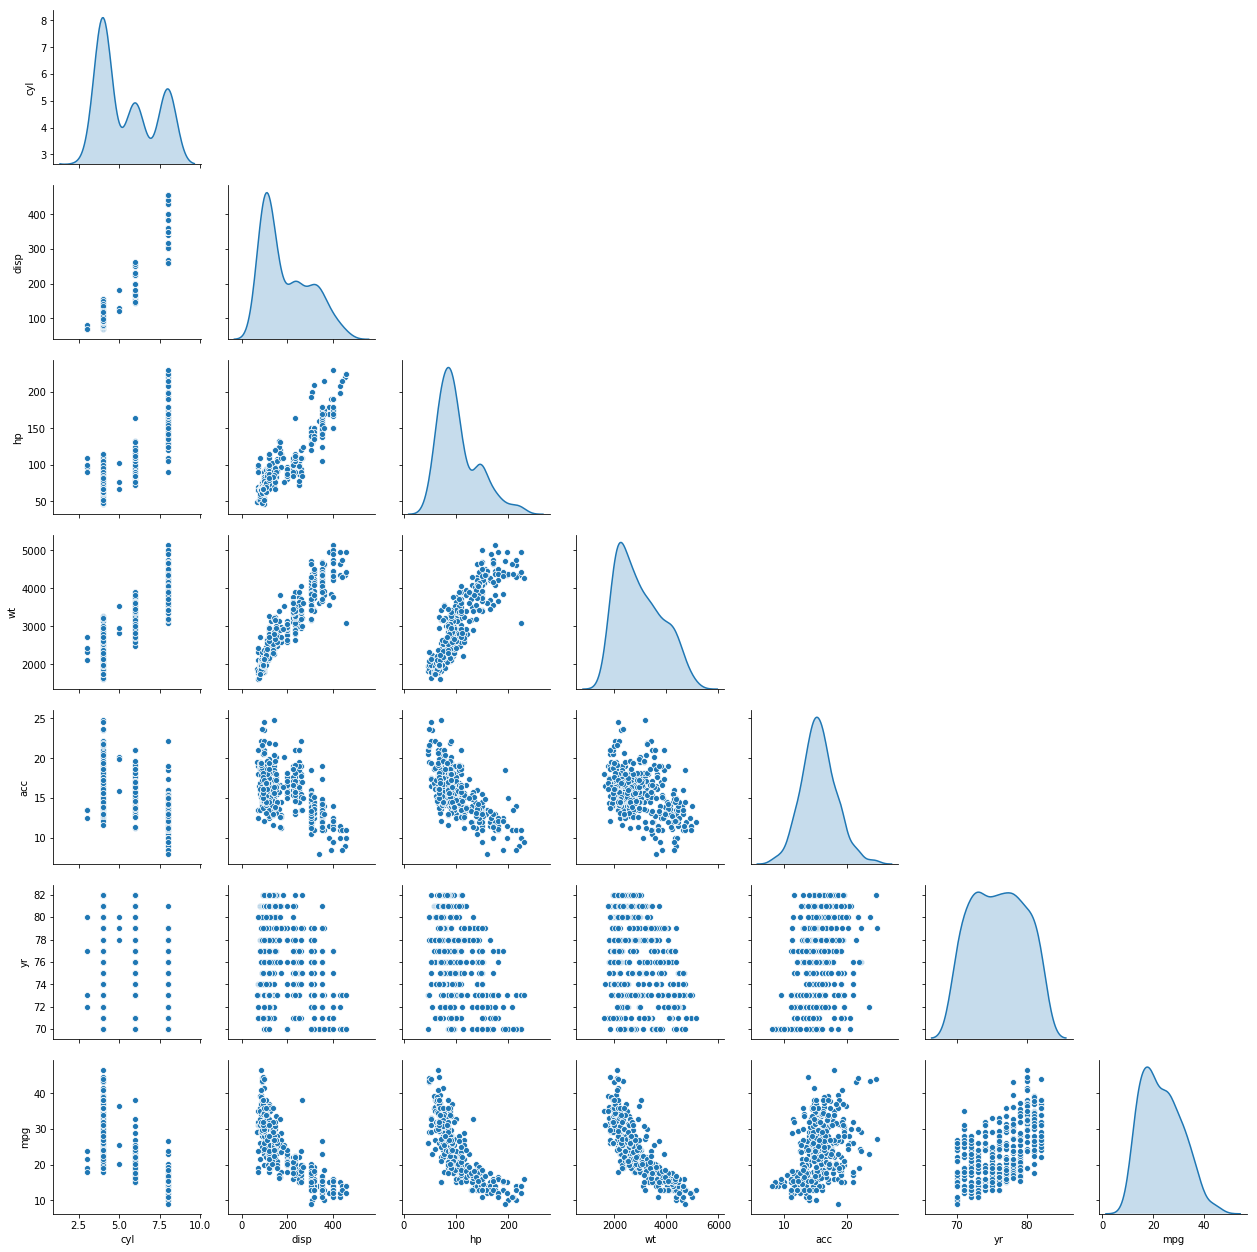

In [11]:
# Do a scatter plot

def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)

g = sns.pairplot(df, diag_kind='kde')
g.map_upper(hide_current_axis)

### From the diagonal kde plots and cyl vs all features plots, we can get an intuition of atleast 3 clusters exisiting in the dataset. Other than that, there is no clear distinction in rest of the pair plots.

## Problem 3. Use K Means or Hierarchical clustering to find out the optimal no of clusters in the data. Identify and separate the clusters (15 points)

### Lets use Hierarchial clustering

In [12]:
#Generate Linkage Matrix

Z = linkage(df, method='ward', metric='euclidean')

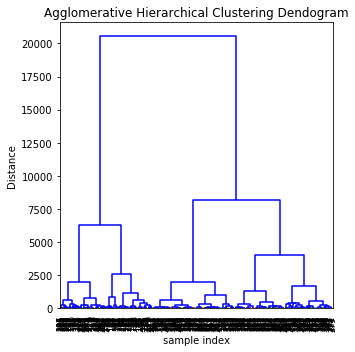

In [13]:
# Lets plot the dendogram

plt.figure(figsize=(5, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 40, leaf_font_size=8.)
plt.tight_layout()

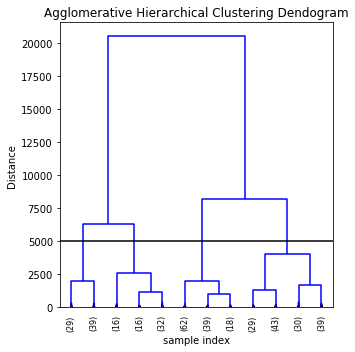

In [14]:
# Now lets plot with truncated mode with 12 clusters and plot an axial line at max distance of 5000 where we see a higher jump of the distances than usual.

max_d = 5000
plt.figure(figsize=(5, 5))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dend = dendrogram(Z, leaf_rotation=90.,
                  color_threshold = 40, 
                  leaf_font_size=8., 
                  p=12, truncate_mode='lastp', 
                  show_contracted=True  )

plt.axhline(y=max_d, c='k')
plt.tight_layout()

### Lets plot elbow curve using K Means to see if our assertion about 4 clusters is correct

In [15]:
clusters_id=range(1,10)
meanDistortions=[]
for k in clusters_id:
    model=KMeans(n_clusters=k)
    model.fit(df)
    prediction=model.predict(df)
    distortions = sum(np.min(distance.cdist(df, model.cluster_centers_, 'euclidean'), axis=1))
    meanDistortions.append( distortions / df.shape[0])

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

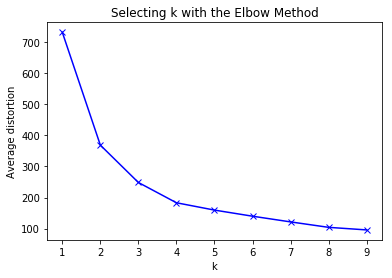

In [16]:
plt.plot(clusters_id, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

### As we can see at k = 4, the distortion curve seem to flatten out and so, we are pretty much confident about our assertion about 4 clusters.

In [17]:
### Lets create the clusters.
max_d = 5000
clusters = fcluster(Z, max_d, criterion='distance')
print(clusters)

[1 1 1 1 1 2 2 2 2 1 1 1 1 4 4 4 4 4 3 3 4 4 4 3 4 2 2 2 2 3 3 3 4 1 1 4 4
 2 2 2 2 2 2 2 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 4 3 2 2 2 2 1 2 2 2 2 4 1 2 2
 2 4 4 4 3 4 3 4 3 3 2 1 1 2 1 2 2 2 2 2 2 1 4 4 4 4 4 3 2 2 2 2 4 3 4 4 3
 3 4 3 2 2 3 3 4 4 1 4 4 1 4 4 1 3 4 3 4 1 1 1 2 2 2 2 2 3 3 3 3 3 3 3 3 4
 4 3 4 1 1 4 2 2 2 2 1 1 1 1 4 4 4 3 4 4 4 4 3 4 4 3 4 4 4 4 4 3 4 3 4 3 3
 2 2 1 2 4 1 4 4 3 3 3 3 1 1 1 4 3 3 3 4 4 1 4 4 1 2 2 1 1 3 3 3 3 3 1 2 2
 2 1 1 1 1 2 2 2 2 3 4 3 4 3 3 3 3 4 4 4 3 3 3 3 3 1 1 1 1 4 4 4 1 4 1 4 1
 1 1 1 4 2 3 4 3 3 4 4 4 4 4 4 4 1 3 3 4 4 4 4 1 1 1 1 1 2 2 1 1 3 3 3 4 1
 1 4 1 3 3 3 3 4 4 4 4 3 3 3 3 4 4 4 1 3 4 4 4 3 3 4 3 3 4 4 4 3 3 3 4 4 4
 3 4 4 4 4 4 3 3 3 3 3 3 3 3 3 4 3 3 4 4 4 4 4 4 4 1 1 4 1 4 4 4 4 4 4 4 3
 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 3 3 4 4]


<Figure size 432x288 with 0 Axes>

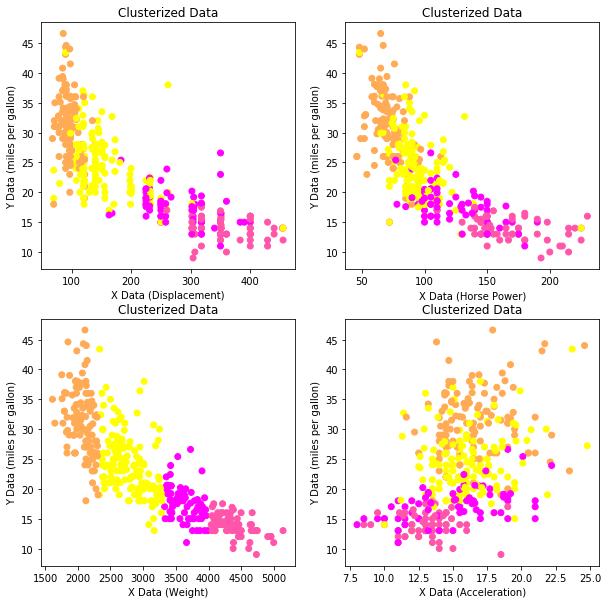

In [18]:
# Plotting to visualize clusters 


f = plt.figure() 
f, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(10, 10))

# Plotting Displacement vs mpg
axes[0][0].scatter(df['disp'], df['mpg'], c=clusters, cmap='spring')  # plot points with cluster dependent colors
axes[0][0].set_title('Clusterized Data')
axes[0][0].set_xlabel('X Data (Displacement)')
axes[0][0].set_ylabel('Y Data (miles per gallon)')

# Plotting Horse Power vs mpg
axes[0][1].scatter(df['hp'], df['mpg'], c=clusters, cmap='spring')  # plot points with cluster dependent colors
axes[0][1].set_title('Clusterized Data')
axes[0][1].set_xlabel('X Data (Horse Power)')
axes[0][1].set_ylabel('Y Data (miles per gallon)')

# Plotting Weight vs mpg
axes[1][0].scatter(df['wt'], df['mpg'], c=clusters, cmap='spring')  # plot points with cluster dependent colors
axes[1][0].set_title('Clusterized Data')
axes[1][0].set_xlabel('X Data (Weight)')
axes[1][0].set_ylabel('Y Data (miles per gallon)')

# Plotting Acceleration vs mpg
axes[1][1].scatter(df['acc'], df['mpg'], c=clusters, cmap='spring')  # plot points with cluster dependent colors
axes[1][1].set_title('Clusterized Data')
axes[1][1].set_xlabel('X Data (Acceleration)')
axes[1][1].set_ylabel('Y Data (miles per gallon)')

plt.show()

### We can visualize 4 clusters in each of the pair plots vs mpg with the most distinct being in Weight vs Miles per gallon and like wise Displacement vs Miles per gallon

### I would also like to use the KPrototypes model from kmodes that specializes in clustering mixed data types as it uses Gower dissimilarity coefficient to see if it would make any difference considering column 1 (cyl) and column 7 (yr) as categorical variables

In [19]:
pip install kmodes

  Using cached https://files.pythonhosted.org/packages/79/c0/f7d8a0eb41ac6f302b4bc100f91b6e0f2558425ccfefaa0ec0430f77ee97/kmodes-0.10.1-py2.py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [20]:
from kmodes.kprototypes import KPrototypes

In [21]:
kproto = KPrototypes(n_clusters=4, init='Cao')
clusters_kmodes = kproto.fit_predict(df, categorical=[0, 6])

<Figure size 432x288 with 0 Axes>

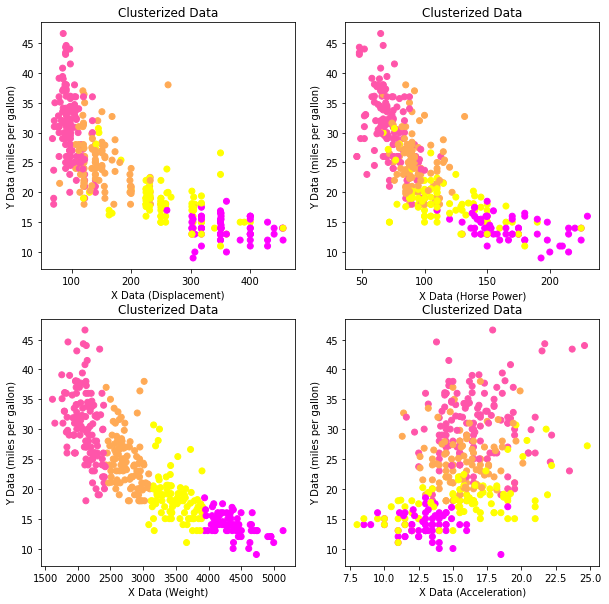

In [22]:
f = plt.figure() 
f, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(10, 10))

# Plotting Displacement vs mpg
axes[0][0].scatter(df['disp'], df['mpg'], c=clusters_kmodes, cmap='spring')  # plot points with cluster dependent colors
axes[0][0].set_title('Clusterized Data')
axes[0][0].set_xlabel('X Data (Displacement)')
axes[0][0].set_ylabel('Y Data (miles per gallon)')

# Plotting Horse Power vs mpg
axes[0][1].scatter(df['hp'], df['mpg'], c=clusters_kmodes, cmap='spring')  # plot points with cluster dependent colors
axes[0][1].set_title('Clusterized Data')
axes[0][1].set_xlabel('X Data (Horse Power)')
axes[0][1].set_ylabel('Y Data (miles per gallon)')

# Plotting Weight vs mpg
axes[1][0].scatter(df['wt'], df['mpg'], c=clusters_kmodes, cmap='spring')  # plot points with cluster dependent colors
axes[1][0].set_title('Clusterized Data')
axes[1][0].set_xlabel('X Data (Weight)')
axes[1][0].set_ylabel('Y Data (miles per gallon)')

# Plotting Acceleration vs mpg
axes[1][1].scatter(df['acc'], df['mpg'], c=clusters_kmodes, cmap='spring')  # plot points with cluster dependent colors
axes[1][1].set_title('Clusterized Data')
axes[1][1].set_xlabel('X Data (Acceleration)')
axes[1][1].set_ylabel('Y Data (miles per gallon)')

plt.show()

### We can see the clustering is very much similar to clustering done by Hierarchial clustering.

## Problem 4. Use linear regression model on different clusters separately and print the coefficients of the models individually (7.5 points)

Text(0, 0.5, 'Y Data (miles per gallon)')

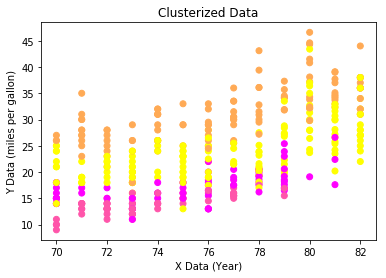

In [23]:
# Lets plot the year vs mpg for the clusters if we need them for Linear Regression

plt.scatter(df['yr'], df['mpg'], c=clusters, cmap='spring')
plt.title('Clusterized Data')
plt.xlabel('X Data (Year)')
plt.ylabel('Y Data (miles per gallon)')

### An interesting observation which I may be wrong about is as the years went by, the cars of a particular cluster became more efficient and generated higher mpg. So, we can still keep the column.

In [24]:
# Go through all clusters, build dataframe, get features and target, build Linear Regression model and populate coefficient values to a dataframe

for i in range(4):
    cids = np.where(clusters == i+1)
    cids_arr = (np.array(cids)).flatten()
    cluster_df = df.iloc[cids_arr,:]
   
    x = cluster_df.drop(labels=['mpg'], axis=1, inplace=False)
    y = cluster_df['mpg']
    model = LinearRegression()
    model.fit(x,y)
    coef = model.coef_
    cols = x.columns.values
    if i == 0:
        coef_df = pd.DataFrame(columns=cols+'_coef')
        
    coef_df.loc[i] = coef
    

index_val = coef_df.index.tolist()
index_val = list(np.array(index_val) + 1)
coef_df.index = index_val
coef_df.index.name = 'Cluster ID'

In [25]:
# Printing the coefficients for each cluster model

coef_df.head()

,cyl_coef,disp_coef,hp_coef,wt_coef,acc_coef,yr_coef
Cluster ID,,,,,,
1,0.358967,0.011437,-0.042153,-0.005076,0.055430,0.454990
2,0.000000,-0.001444,-0.015024,-0.002097,-0.390642,0.428060
3,10.660627,-0.064263,0.006434,-0.007419,0.112125,1.017085
4,0.062257,-0.002617,-0.054358,-0.007290,0.091811,0.775665
